In [1]:
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from dataset import TreeStimuli
from copy import deepcopy

In [12]:
Trees = TreeStimuli()
Trees.stimuli
Trees.shuffle()


array([[1. , 0.2],
       [0.8, 1. ],
       [0.6, 0.8],
       [0.8, 0.6],
       [1.2, 0.2],
       [0.2, 1.2],
       [0.4, 0.8],
       [0.2, 0.6],
       [1. , 0.8],
       [1.2, 1. ],
       [1. , 1. ],
       [0.4, 0.6],
       [0.8, 0.4],
       [0.6, 0.4],
       [0.6, 1. ],
       [0.4, 1. ],
       [0.8, 0.8],
       [0.4, 0.4],
       [1.2, 0.6],
       [1.2, 1.2],
       [0.4, 1.2],
       [1. , 0.4],
       [1.2, 0.8],
       [0.4, 0.2],
       [1. , 0.6],
       [0.6, 0.6],
       [0.2, 1. ],
       [0.2, 0.8],
       [0.6, 0.2],
       [0.2, 0.2],
       [0.8, 0.2],
       [0.6, 1.2],
       [1. , 1.2],
       [1.2, 0.4],
       [0.8, 1.2],
       [0.2, 0.4]])

In [9]:
class Neuron():
  def __init__(self,activation_function) -> None:
    self.activate=activation_function

  def fire(self,stimuli):
    return self.activate(stimuli) 

class Ensemble():
  def __init__(self,activation_functions:list) -> None:
    self.neurons = [Neuron(func) for func in activation_functions]
    self.n_neuron = len(self.neurons)

  def fire(self,stimuli):
    return np.array([n.fire(stimuli) for n in self.neurons]).T

sigmoid = lambda x: 1/(1+np.exp(-x))
gaussian = lambda x: scipy.stats.norm(0.75,0.5).pdf(x)
gaussians = [lambda x: scipy.stats.norm(0.53,0.33).pdf(x),
             lambda x: scipy.stats.norm(0.86,0.33).pdf(x)]
g_noise = lambda: 0#np.random.normal(0,0.1)

Linear_PureSelective_Ensemble = Ensemble([lambda x: x[:,0]+g_noise(),lambda x: x[:,1]+g_noise()])
Linear_MixedSelective_Ensemble = Ensemble([lambda x: 0.5*x[:,0]+0.5*x[:,1]+g_noise(),lambda x: .8*x[:,1]+.2*x[:,0]+g_noise()])
Nonlinear_MixedSelctive_Ensemble = Ensemble([lambda x: gaussian(x[:,0])+gaussian(x[:,1])+g_noise(),
                                             lambda x: 2.5*x[:,0]+2.5*x[:,1]+g_noise()])
PolarNeuronEnsemble = Ensemble([lambda x: x[:,0]*np.cos(x[:,1]*np.pi)+g_noise(),
                                lambda x: x[:,0]*np.sin(x[:,1]*np.pi)+g_noise()])
GaussianNeuronEnsemble_1_1 = Ensemble([lambda x: gaussian(x[:,0])+g_noise(),
                                       lambda x: gaussian(x[:,1])+g_noise()])
GaussianNeuronEnsemble_1_2 = Ensemble([lambda x: gaussian(x[:,0])+g_noise(),
                                       lambda x: gaussians[0](x[:,1])+g_noise(),
                                       lambda x: gaussians[1](x[:,1])+g_noise()])
GaussianNeuronEnsemble_2_2 = Ensemble([lambda x: gaussians[0](x[:,0])+g_noise(),
                                       lambda x: gaussians[0](x[:,1])+g_noise(),
                                       lambda x: gaussians[1](x[:,0])+g_noise(),
                                       lambda x: gaussians[1](x[:,1])+g_noise()])

In [7]:
gaussian = lambda x: scipy.stats.norm(0.5,0.33).pdf(x)
for x in np.linspace(0.2,1.4,6,False):
    print(f'firing rate at x={x} is {gaussian(x)}')

firing rate at x=0.2 is 0.7997156522537272
firing rate at x=0.4 is 1.154665173692339
firing rate at x=0.6 is 1.154665173692339
firing rate at x=0.8 is 0.7997156522537272
firing rate at x=1.0 is 0.3836141820910355
firing rate at x=1.2 is 0.12744806378007634


In [14]:
X = GaussianNeuronEnsemble_1_2.fire(Trees.stimuli)
X.shape

(36, 3)

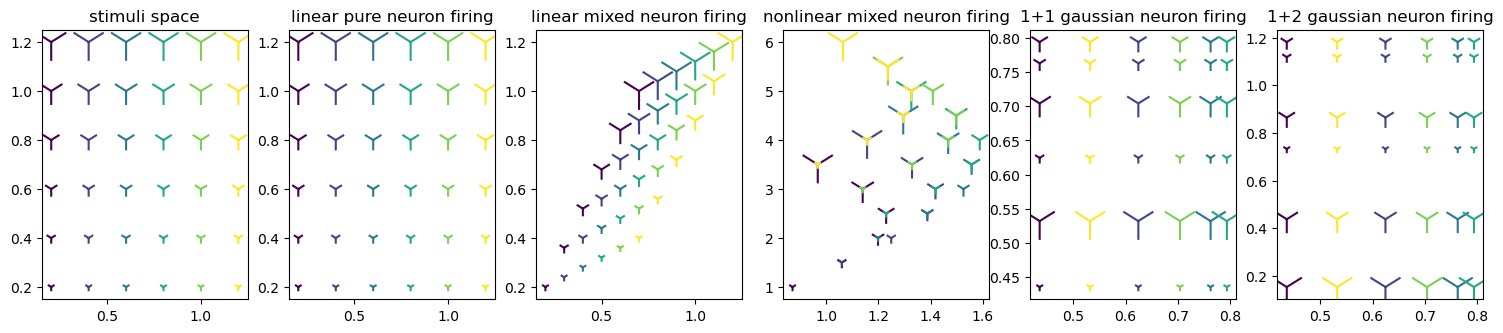

In [10]:
stim_space = deepcopy(Trees.stimuli)

spaces = {
    "stimuli space":stim_space,
    "linear pure neuron firing": Linear_PureSelective_Ensemble.fire(Trees.stimuli),
    "linear mixed neuron firing": Linear_MixedSelective_Ensemble.fire(Trees.stimuli),
    "nonlinear mixed neuron firing": Nonlinear_MixedSelctive_Ensemble.fire(Trees.stimuli),
    #"polar neuron firing": PolarNeuronEnsemble.fire(Trees.stimuli),
    "1+1 gaussian neuron firing": GaussianNeuronEnsemble_1_1.fire(Trees.stimuli),
    "1+2 gaussian neuron firing": GaussianNeuronEnsemble_1_2.fire(Trees.stimuli),
    #"2+2 gaussian neuron firing": GaussianNeuronEnsemble_2_2.fire(Trees.stimuli)
}

fig_fspace,ax_fspace = plt.subplots(1,len(spaces),figsize=(3.1*len(spaces),3.5))
for js,(s_name,s_mat) in enumerate(spaces.items()):
    ax_fspace[js].scatter(x=s_mat[:,0],y=s_mat[:,1],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
    ax_fspace[js].set_title(s_name)

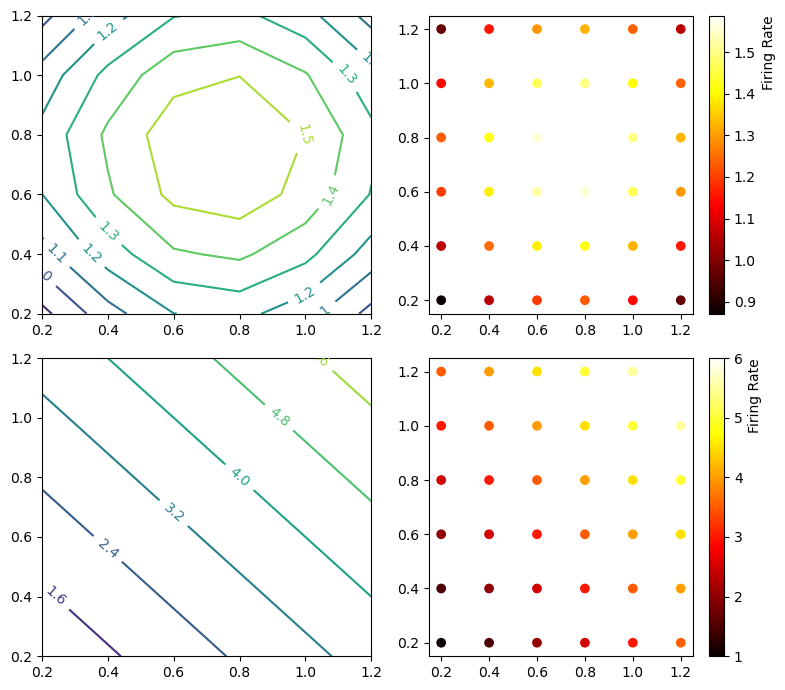

In [15]:
F1, F2 = np.reshape(stim_space[:,0],(6,6)),np.reshape(stim_space[:,1],(6,6))
firing_space = Nonlinear_MixedSelctive_Ensemble.fire(Trees.stimuli)
fig, ax = plt.subplots(2,2,figsize=(8,7))
for j in range(firing_space.shape[1]):
    H = np.reshape(firing_space[:,j],(6,6))
    cs=ax[j,0].contour(F1, F2, H)
    ax[j,0].clabel(cs, inline=True, fontsize=10)
    sc=ax[j,1].scatter(x=stim_space[:,0],y=stim_space[:,1],c=firing_space[:,j],cmap="hot")
    cbar = fig.colorbar(sc)
    cbar.set_label("Firing Rate", loc='top')
fig.tight_layout()    

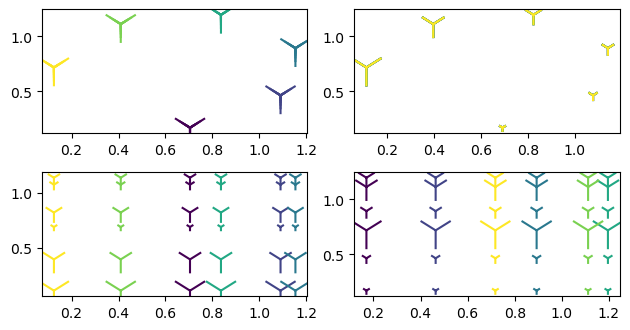

In [105]:
coords = deepcopy(GaussianNeuronEnsemble_2_2.fire(Trees.stimuli))
fig = plt.figure()
ax1 = fig.add_subplot(321)
ax1.scatter(coords[:,0],coords[:,2],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
ax2 = fig.add_subplot(322)
ax2.scatter(coords[:,1],coords[:,3],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
ax3 = fig.add_subplot(323)
ax3.scatter(coords[:,0],coords[:,1],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
ax4 = fig.add_subplot(324)
ax4.scatter(coords[:,2],coords[:,3],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
fig.tight_layout()

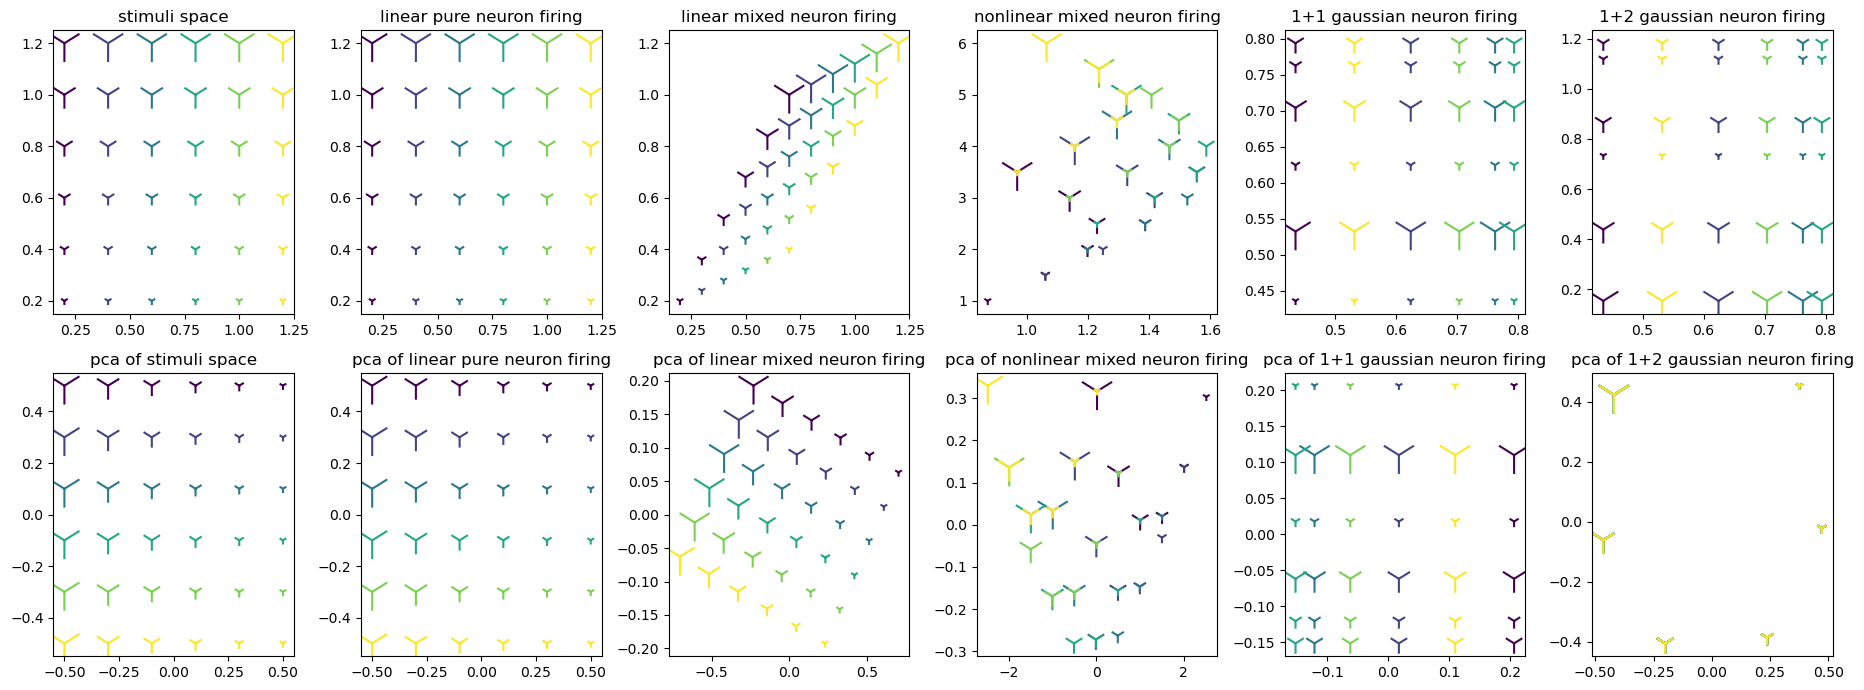

In [16]:
from sklearn.decomposition import PCA
pca_sapce = {}
for js,(s_name,s_mat) in enumerate(spaces.items()):
    pca_sapce |= {s_name:PCA(n_components=2).fit_transform(s_mat)}

fig_fspace,ax_fspace = plt.subplots(2,len(spaces),figsize=(3.1*len(spaces),7))
for js,(s_name,s_mat) in enumerate(spaces.items()):
    ax_fspace[0,js].scatter(x=s_mat[:,0],y=s_mat[:,1],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
    ax_fspace[0,js].set_title(s_name)
    ax_fspace[1,js].scatter(x=pca_sapce[s_name][:,0],y=pca_sapce[s_name][:,1],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
    ax_fspace[1,js].set_title('pca of '+s_name)
fig_fspace.tight_layout()